<Axes: >

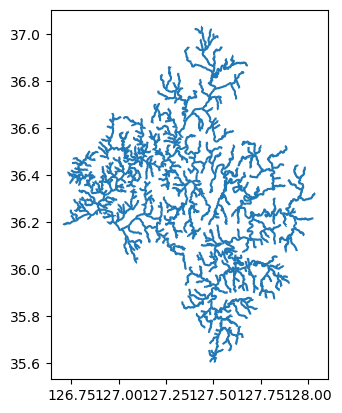

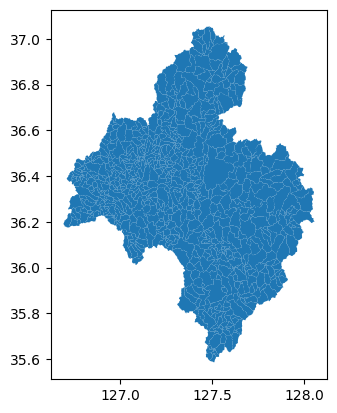

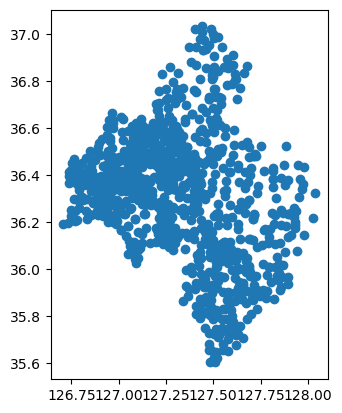

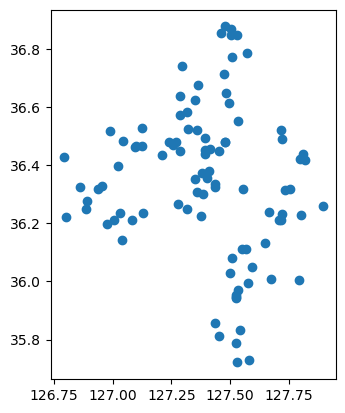

In [1]:
import geopandas as gpd

# KRF로 시작하는 shapefile 찾기
shapefiles = [r"./src/shp/KRF_ver3_CATCHMENT_금강수계.shp",
              r"./src/shp/KRF_ver3_LINE_금강수계.shp",
              r"./src/shp/KRF_ver3_NODE_금강수계.shp",
              r"./src/shp/MASKED2_MMCAT.shp",
              r"./src/shp/merged_geum_river_basin_utf8.shp"]

# shapefile 읽기
masked = gpd.read_file(shapefiles[3])

if masked.crs.to_string() != 'EPSG:4326':
    masked = masked.to_crs(epsg=4326)


catchment_gdf = gpd.clip(gpd.read_file(shapefiles[0]),   masked)
streamline_gdf = gpd.clip(gpd.read_file(shapefiles[1]), masked)
node_gdf = gpd.clip(gpd.read_file(shapefiles[2]), masked)
stations_gdf = gpd.clip(gpd.read_file(shapefiles[4], encoding="utf-8"), masked)

# 시각화

streamline_gdf.plot()
catchment_gdf.plot()
node_gdf.plot()
stations_gdf.plot()


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from shapely.ops import nearest_points

# 노드와 스트림라인 데이터프레임을 가져오기 (예시로 gdfs 중 첫 번째 사용)



# 서브그래프 생성
G = nx.Graph()

# 노드 추가
for idx, row in node_gdf.iterrows():
    x, y = row['geometry'].x, row['geometry'].y
    # row.pop('geometry')
    G.add_node(row['NODE_DID'], pos=(x, y), attr=row.to_dict(), node_type="stream_node")
    

# # 엣지 추가 (INODE_ID -> ONODE_ID)
for idx, row in streamline_gdf.iterrows():
    # row.pop('geometry')
    G.add_edge(row['INODE_DID'], row['ONODE_DID'], attr=row.to_dict())



# 관측소에 가장 가까운 하천 지점 노드에 관측소 코드를 부여
for idx, station in stations_gdf.iterrows():
    station_point = station.geometry
    nearest_geom = nearest_points(station_point, node_gdf.unary_union)[1]
    nearest_node = node_gdf[node_gdf.geometry == nearest_geom]['NODE_DID'].values[0]
    G.nodes[nearest_node]["attr"]["gauge_code"] = int(station["Code"])


for idx, catchment in catchment_gdf.iterrows():
    # catchment의 폴리곤 내에 있는 node_type = "stream_node"인 노드들을 찾아서 해당 catchment의 라벨을 부여
    # !TODO
    catchment_polygon = catchment.geometry
    for node_id in G.nodes():
        node = G.nodes[node_id]
        if "node_type" in node and node["node_type"] == "stream_node":
            node_point = node["attr"]["geometry"]
            if catchment_polygon.contains(node_point):
                node["attr"]["catchment_label"] = catchment["SB_ID"]
                node["attr"]["catchment_area"] = catchment["AREA"]

G.remove_node('3014010101')

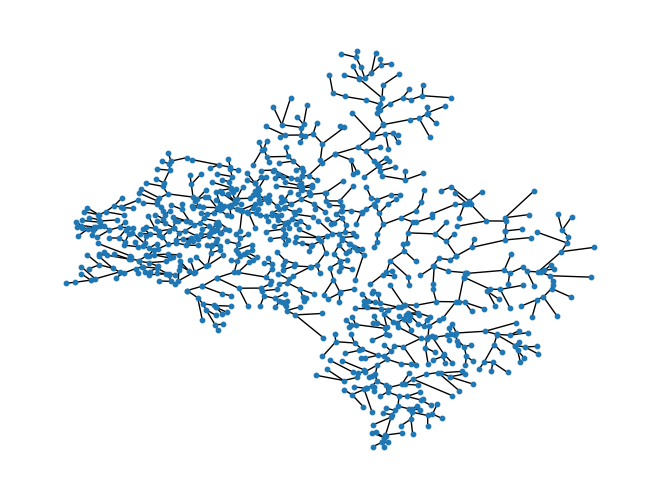

In [3]:
# 구축한 그래프를 시각화
nx.draw(G, pos=nx.get_node_attributes(G, 'pos'), node_size=10)

In [7]:
for node_idx, node_data in G.nodes(data=True):
    if "gauge_code" in node_data["attr"]:
        G.nodes[node_idx]["attr"]["is_gauged"] = 1
    else:
        G.nodes[node_idx]["attr"]["is_gauged"] = 0
    

In [39]:
is_gauged = []
for node_idx, node_data in G.nodes(data=True):
    if "is_gauged" in node_data["attr"]:
        is_gauged.append(node_data["attr"]["is_gauged"])
len(is_gauged), sum(is_gauged)
        

(943, 87)

In [14]:
import pandas as pd
wl_df = pd.read_csv(r"./src/timeseries/wl.csv")
wl_df.index = pd.to_datetime(wl_df["ymd"])
# fill wl values to 0 if there's negative value
wl_df["wl"] = wl_df["wl"].apply(lambda x: 0 if x < 0 else x)
wl_df["Station_Co"] = wl_df["Station_Co"].astype(int)
weather = pd.read_csv(r"C:\Users\82105\GNN\geumdata\weather.csv", encoding="cp949")
weather.index = pd.to_datetime(weather["일시"])
weather = weather[["평균기온(°C)","최고기온(°C)", "최저기온(°C)", "일강수량(mm)", "평균 풍속(m/s)", "평균 상대습도(%)"]]
weather.rename(columns={"평균기온(°C)":"temp", "최고기온(°C)":"tmax",\
                         "최저기온(°C)":"tmin", "일강수량(mm)":"rf", "평균 풍속(m/s)":"wind", "평균 상대습도(%)":"humidity"}, inplace=True)
weather["rf"] = weather["rf"].fillna(0)
weather.interpolate(method="polynomial", order=3, inplace=True)

wl_mean, wl_std = wl_df["wl"].mean(), wl_df["wl"].std()

wl_df["wl"] = (wl_df["wl"] - wl_df["wl"].mean()) / wl_df["wl"].std()
weather["temp"] = (weather["temp"] - weather["temp"].mean()) / weather["temp"].std()
weather["tmax"] = (weather["tmax"] - weather["tmax"].mean()) / weather["tmax"].std()
weather["tmin"] = (weather["tmin"] - weather["tmin"].mean()) / weather["tmin"].std()
weather["rf"] = (weather["rf"] - weather["rf"].mean()) / weather["rf"].std()

In [40]:
import numpy as np

def generate_dynamic_graph_at_time_t(G:nx.Graph, time, wl:pd.DataFrame, weather:pd.DataFrame):
    G_t = G.copy()
    for node in G_t.nodes(data=True):
                is_gauged = np.int32(node[1]['attr']['is_gauged'])  # Convert to numpy.int32
                if is_gauged == 1:
                    gauge_code = np.int32(node[1]['attr']['gauge_code'])
                    wl["wl"][wl["Station_Co"] == gauge_code]
                    G_t.nodes[node[0]]['attr']['water_level'] = wl["wl"][wl["Station_Co"] == gauge_code].loc[time]
                    G_t.nodes[node[0]]['attr']['rf'] = weather["rf"][time]
                    G_t.nodes[node[0]]['attr']['tmax'] = weather["tmax"][time]
                    G_t.nodes[node[0]]['attr']['tmin'] = weather["tmin"][time]
                else:
                    G_t.nodes[node[0]]['attr']['water_level'] = -1
                    G_t.nodes[node[0]]['attr']['rf'] = weather["rf"][time]
                    G_t.nodes[node[0]]['attr']['tmax'] = weather["tmax"][time]
                    G_t.nodes[node[0]]['attr']['tmin'] = weather["tmin"][time]
    return G_t

In [20]:
G_t_sample = generate_dynamic_graph_at_time_t(G, "2022-01-01", wl_df, weather)

In [22]:
G_t_sample.nodes(data=True)

NodeDataView({'3001010200': {'pos': (127.50858106500004, 35.60253993600003), 'attr': {'OBJECTID': 2748, 'NODE_ID': '30010102', 'NODE_DID': '3001010200', 'NODE_X': 127.508581, 'NODE_Y': 35.60254, 'WGM_ID': None, 'WGM_NM': None, 'WTM_ID': None, 'WTM_NM': None, 'WAM_ID': None, 'WAM_NM': None, 'DAM_NM': None, 'BO_NM': None, 'LU_RCH_ID': None, 'LU_RCH_DID': None, 'RU_RCH_ID': None, 'RU_RCH_DID': None, 'LD_RCH_ID': '30010102', 'LD_RCH_DID': '3001010200', 'RD_RCH_ID': None, 'RD_RCH_DID': None, 'NODE_SN': '02', 'NODE_DIV': '00', 'RCH_NUM': 1.0, 'S_FLAG': 1.0, 'E_FLAG': 0.0, 'C_FLAG': 0.0, 'DAM_FLAG': 0.0, 'BO_FLAG': 0.0, 'WGM_FLAG': 0.0, 'WTM_FLAG': 0.0, 'WAM_FLAG': 0.0, 'SB_FLAG': 0.0, 'R_FLAG': 0.0, 'FLAG_ID': '0000000', 'geometry': <POINT (128 35.6)>, 'catchment_label': '300101', 'catchment_area': 6.724434, 'is_gauged': 0, 'water_level': -1, 'rf': -0.23781598387504055, 'tmax': -1.7976696788496236, 'tmin': -1.7796817628708714}, 'node_type': 'stream_node'}, '3001010100': {'pos': (127.48068907

In [41]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader, Dataset
import torch_geometric
import networkx as nx
import torch_geometric.transforms as T

mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, mapping)

time_steps = weather.index
graphs = []
node_features = []

for t in time_steps:
    G_t = generate_dynamic_graph_at_time_t(G, str(t).split(" ")[0], wl_df, weather)
    # Extract node features
    features = []
    for node in G_t.nodes(data=True):
        attr = node[1]['attr']
        features = [attr.get('water_level', -1), attr.get('rf', -1), attr.get('tmax', -1), attr.get('tmin', -1)]
        node_features.append(features)
    
    x = torch.tensor(node_features, dtype=torch.float)
    edge_index = torch.tensor([(u, v) for u, v, data in G.edges(data=True)]).t().contiguous()    
    data = Data(x=x, edge_index=edge_index, transform=T.NormalizeFeatures())
    graphs.append(data)
    node_features = []


In [43]:
train_graphs = graphs[:int(len(graphs)*0.5)]
test_graphs = graphs[int(len(graphs)*0.5):]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

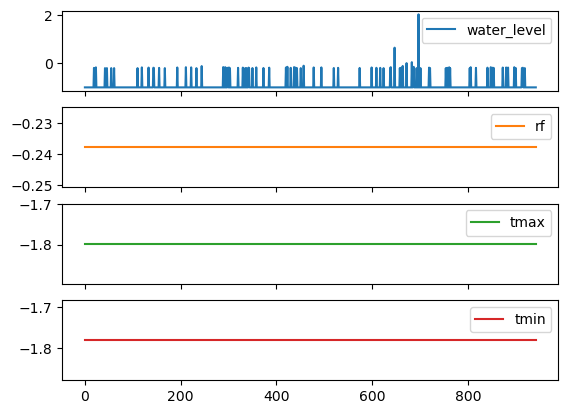

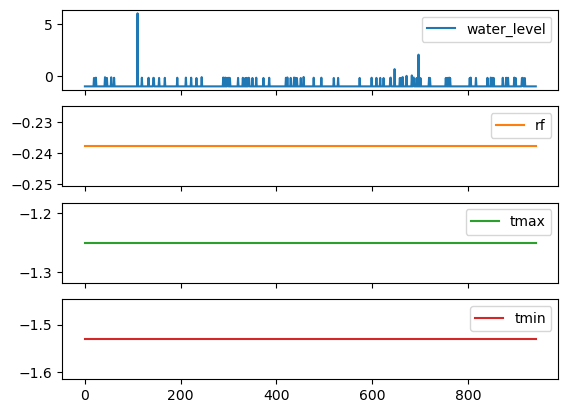

In [45]:
test_df = pd.DataFrame(graphs[0].x.numpy(), columns=["water_level", "rf", "tmax", "tmin"])
test_df.plot(subplots=True)

test_df2 = pd.DataFrame(graphs[1].x.numpy(), columns=["water_level", "rf", "tmax", "tmin"])
test_df2.plot(subplots=True)

In [46]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GAE

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv2(x, edge_index)

# Parameters
in_channels = 4
out_channels = 64

# Create model
encoder = GCNEncoder(in_channels, out_channels)
model = GAE(encoder)


# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training function
def train():
    model.train()
    optimizer.zero_grad()
    total_loss = 0
    for data in graphs:
        z = model.encode(data.x, data.edge_index)
        loss = model.recon_loss(z, data.edge_index)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(graphs)

# Training loop
epochs = 10
for epoch in range(epochs):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss:.4f}')

Epoch 0, Loss: 4.4840


In [47]:
model.eval()
with torch.no_grad():
    results = []
    for data in graphs:
        z = model.encode(data.x, data.edge_index)
        # Reconstructed edge indices
        edge_index_pred = model.decode(z, data.edge_index)
        results.append(z)
    

In [53]:
# for only gauged nodes
gauged_results = []

gagued_node_idx = np.where(np.array(is_gauged) == 1)
for time in range(len(results)):
    for idx in gagued_node_idx:
        gauged_results.append(results[time][idx])



In [58]:
gagued_node_idx

(array([ 19,  23,  42,  46,  55,  61, 110, 119, 133, 143, 144, 155, 167,
        193, 211, 222, 233, 244, 289, 293, 295, 298, 299, 301, 303, 320,
        330, 335, 338, 342, 343, 350, 358, 373, 385, 420, 423, 430, 437,
        440, 443, 451, 457, 478, 494, 520, 529, 574, 599, 609, 617, 624,
        638, 639, 647, 658, 661, 664, 672, 683, 686, 687, 693, 697, 701,
        719, 721, 754, 757, 761, 763, 804, 806, 817, 841, 848, 852, 854,
        873, 880, 884, 897, 900, 913, 914, 915, 919], dtype=int64),)

In [89]:
embeddings = torch.stack(gauged_results)

import torch.nn as nn

# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

        # # LSTM expects input as (batch_size, seq_len, input_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        out = out.unsqueeze(-1)
        return out
    
model = LSTMModel()


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings, target_node, wl_df, gauged_node_idx ,window_size=7, dataset_type="train"):
        """
        Args:
            embeddings (torch.Tensor): The embeddings tensor of shape (730, 87, 64).
            target_node (int): The index of the target node to predict.
            window_size (int): The number of days to use for prediction.
        """
        self.embeddings = embeddings
        self.target_node = target_node
        self.window_size = window_size
        self.gauged_node_idx = gauged_node_idx
        self.mapping = {node:number for node, number in zip(gauged_node_idx, range(len(gauged_node_idx)))}
        
        self.wl = wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].values
        self.wl_mean, self.wl_std = self.wl.mean(), self.wl.std()
        self.wl = (self.wl - self.wl_mean) / self.wl_std


    def __len__(self):
        return len(self.embeddings) - self.window_size

    def __getitem__(self, idx):
        """
        Returns a tuple (input_sequence, target_value) where:
        - input_sequence is the embeddings for the target node over the past `window_size` days
        - target_value is the target node's embedding for the next day
        """

        input_sequence = self.embeddings[idx:idx + self.window_size,  self.mapping[self.target_node], :]
        target_value = torch.tensor(self.wl[idx + self.window_size], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        return input_sequence, target_value

# Example usage
target_node = 19 # Example target node index
dataset = CustomDataset(embeddings, target_node, gauged_node_idx=gagued_node_idx[0] ,wl_df=wl_df)

# Check the first item
input_sequence, target_value = dataset[0]
print(f"Input sequence shape: {input_sequence.shape}")  # Should be (7, 64)
print(f"Target value shape: {target_value.shape}")      # Should be (64,)



Input sequence shape: torch.Size([7, 64])
Target value shape: torch.Size([1, 1])


In [90]:
dataset.mapping[19]

0

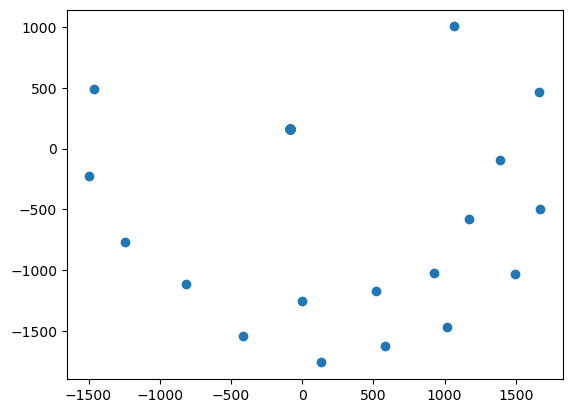

In [91]:
# using TSNE, check the embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
embeddings_2d = tsne.fit_transform(embeddings.numpy()[0])
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])


In [65]:
embeddings.numpy()[0].shape

(87, 64)

In [ ]:
# train the lstm model
# 2022년 학습 2023년 평가
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
def train(model, train_loader):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        total_loss = 0
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)
# Train the model
for epoch in range(100):
    for target_node in gagued_node_idx[0]:
        dataset = CustomDataset(embeddings[:365], target_node, gauged_node_idx=gagued_node_idx[0] ,wl_df=wl_df)
        train_loader = DataLoader(dataset, batch_size=64)
        loss = train(model, train_loader)
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}')

In [110]:
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader

def plot_and_save_prediction(model, target_node, embeddings, wl_df):
    model.eval()
    observations = []
    predictions = []

    test_loader = DataLoader(CustomDataset(embeddings, target_node, gauged_node_idx=gagued_node_idx[0] ,wl_df=wl_df), batch_size=1)
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            observations.append(targets.reshape(-1).numpy())
            predictions.append(outputs.reshape(-1).numpy())

    observations = np.concatenate(observations)
    predictions = np.concatenate(predictions)

    # find wl_std, wl_mean for given target node
    wl_mean, wl_std = wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].mean(), wl_df["wl"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].std()
    observations_value = observations * wl_std + wl_mean
    predictions_value = predictions * wl_std + wl_mean

    plt.plot(observations_value, label='Observations')
    plt.plot(predictions_value, label='Predictions')
    plt.legend()
    plt.title(f'Water Level Prediction for Node {target_node}')
    plt.savefig(f'prediction_{target_node}.png')
    plt.close()

    # save results to a csv file
    results = pd.DataFrame({"Observations": observations_value, "Predictions": predictions_value, "Station_Co": G.nodes[target_node]["attr"]["gauge_code"], "Station_Name": wl_df["측정소명"][wl_df["Station_Co"] == G.nodes[target_node]["attr"]["gauge_code"]].values[0]})
    results.to_csv("./results/results_{}.csv".format(target_node), index=False)

# Use the function for each target node
for target_node in gagued_node_idx[0]:
    plot_and_save_prediction(model, target_node, embeddings, wl_df)

In [115]:
import glob
paths = glob.glob("./results/results_*.csv")
dfs = [pd.read_csv(path) for path in paths]

# make evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score
def kge(y_obs, y_sim):
    r = np.corrcoef(y_obs, y_sim)[0,1]
    alpha = np.std(y_sim) / np.std(y_obs)
    beta = np.sum(y_sim) / np.sum(y_obs)
    kge = 1 - np.sqrt((r-1)**2 + (alpha-1)**2 + (beta-1)**2)
    return kge

def nse(y_obs, y_sim):
    mean_obs = np.mean(y_obs)
    numerator = np.sum((y_obs - y_sim) ** 2)
    denominator = np.sum((y_obs - mean_obs) ** 2)
    nse = 1 - numerator / denominator
    return nse

def evaluate_results(results):
    rmse = np.sqrt(mean_squared_error(results["Observations"], results["Predictions"]))
    r2 = r2_score(results["Observations"], results["Predictions"])
    kge_score = kge(results["Observations"], results["Predictions"])
    nse_score = nse(results["Observations"], results["Predictions"])
    station_name = results["Station_Name"].values[0]
    station_code = results["Station_Co"].values[0]
    return rmse,  kge_score, nse_score, station_name, station_code

# Evaluate each result
evaluation_results = [evaluate_results(df) for df in dfs]
evaluation_df = pd.DataFrame(evaluation_results, columns=["RMSE", "KGE", "NSE", "Station_Name", "Station_Code"])
evaluation_df.to_csv("evaluation_results.csv", index=False)